In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, KFold
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, max_error, explained_variance_score
from sklearn.model_selection import train_test_split
import seaborn as sns
import statsmodels.api as sm

from google.colab import drive
drive.mount('/content/gdrive')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Utility functions

In [ ]:
def compute_metrics(real, predicted):
  print('Maximum residuals error: ' + str(max_error(real, predicted)))
  print('Mean squared error: ' + str(mean_squared_error(real, predicted)))
  print('Mean absolute error: ' + str(mean_absolute_error(real, predicted)))
  print('R-squared score: ' + str(r2_score(real, predicted)))
  print('Explained variance: ' + str(explained_variance_score(real, predicted)))
  return max_error(real, predicted), \
  mean_squared_error(real, predicted), \
  mean_absolute_error(real, predicted), \
  r2_score(real, predicted), \
  explained_variance_score(real, predicted) \

def plot_residuals_histogram(real, predicted, fig_title, colour = 'tab:blue'):
  diff = pd.Series(real - predicted)
  diff.hist(bins = 40, color = colour, edgecolor='black', linewidth=0.3)
  plt.title(fig_title)
  plt.xlabel('Prediction Error')
  plt.ylabel('Frequency')

def plot_residuals_scatter(real, predicted, fig_title, colour = 'tab:blue'):
  plt.rcParams['figure.figsize'] = (6.0, 6.0)
  residuals_df = pd.DataFrame({"predicted": predicted, "true": real})
  residuals_df["residuals"] = residuals_df["true"] - residuals_df["predicted"]
  residuals_df.plot(x = "predicted", y = "residuals", kind = "scatter", title = fig_title, color = colour)

def plot_qq(real, predicted, fig_title, colour = 'tab:blue'):
  fig = plt.figure(figsize = (6,6))
  fig.clf()
  ax = fig.gca()
  residuals_df = pd.DataFrame({"predicted": predicted, "true": real})
  residuals_df["residuals"] = residuals_df["true"] - residuals_df["predicted"]
  sm.qqplot(residuals_df['residuals'], ax = ax, color = colour)
  ax.set_title(fig_title)

def plot_predictions(predictions):
  cn_uniques = predictions['CountryName'].unique()

  for cn in cn_uniques:
    data = predictions[predictions['CountryName'] == cn]
    data['Year'] = data['Year'].astype(int)
    fig = plt.figure(figsize=(8, 6))
    fig.clf()
    plt.plot(data['Year'], data['GDP growth (annual %)'], 'k')
    plt.plot(data['Year'], data['Predicted LM'], 'g1')
    plt.plot(data['Year'], data['Predicted DT'], 'm2')
    plt.plot(data['Year'], data['Predicted RF'], 'bx')
    plt.plot(data['Year'], data['Predicted XGB'], 'r+')
    plt.gca().legend(('Actual','Predicted LM', 'Predicted DT', 'Predicted RF', 'Predicted XGB'), loc = 'best')
    plt.xlabel("Years from start of plot")
    plt.ylabel("GDP growth (%)")
    plt.title("Evolution of GDP over time in {}".format(cn))
    plt.show()

## GDP per Capita prediction

In [ ]:
df = pd.read_csv('/content/gdrive/My Drive/AI Masters/Data Visualization/IndicatorsV2_Normalized.csv')

train_data = df.drop(labels = ['Country', 'GDP per capita (current US$)'], axis = 1)
train_labels = df['GDP per capita (current US$)']

rfr_selector = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=490,
                      max_features=80, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=52, min_samples_split=251,
                      min_weight_fraction_leaf=0.0, n_estimators=1300,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

rfr_selector.fit(train_data, train_labels)

coefs = pd.Series(rfr_selector.feature_importances_, index = train_data.columns)

coefs.sort_values(ascending = False, inplace = True)

In [ ]:
coefs_for_plot = coefs[:5]
plt.rcParams['figure.figsize'] = (8.0, 16.0)
coefs_for_plot.plot(kind = "barh")
plt.title("Coefficients' importance as chosen by the random forest model.")

In [ ]:
cols = list(coefs.keys()[:30])
cols.append('Country')
cols.append('GDP per capita (current US$)')

df_select = df[cols]

parameters_cv_rf = {
  'bootstrap': [True],
  'n_estimators': [trees for trees in range(100, 2000, 50)],
  'max_depth': [depth for depth in range(10, 500, 10)],
  'min_samples_leaf': range(2, 100, 5),
  'min_samples_split': [sample for sample in range(2, 500, 50)],
  'max_features': [degree_freedom for degree_freedom in range(2, 37, 5)]
}

features = df_select.drop(['Country', 'GDP per capita (current US$)'], axis = 1)

labels = df_select['GDP per capita (current US$)'].values

rf_model = RandomForestRegressor(random_state = 42)

kf = KFold(n_splits = 10, shuffle = False, random_state = 1001)

random_search = RandomizedSearchCV(rf_model, 
                                   param_distributions = parameters_cv_rf, 
                                   n_iter = 10, 
                                   scoring = 'neg_mean_squared_error', 
                                   n_jobs = 100, 
                                   cv = kf.split(features, labels), 
                                   verbose = 10, 
                                   random_state = 1001)

random_search.fit(features, labels)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.
[Parallel(n_jobs=100)]: Done  11 out of 100 | elapsed:  1.2min remaining: 10.0min
[Parallel(n_jobs=100)]: Done  22 out of 100 | elapsed:  1.4min remaining:  4.8min
/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=100)]: Done  33 out of 100 | elapsed: 12.2min remaining: 24.7min
[Parallel(n_jobs=100)]: Done  44 out of 100 | elapsed: 39.3min remaining: 50.0min
[Parallel(n_jobs=100)]: Done  55 out of

RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x7f85300833d0>,
                   error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf...
                              

In [ ]:
print('Best estimator:')
print(random_search.best_estimator_)
print('\n Best normalized gini score for %d-fold search with %d parameter combinations:' % (10, 10))
print(random_search.best_score_ * 2 - 1)
print('\n Best hyperparameters:')
print(random_search.best_params_)

Best estimator:
RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=220, max_features=17, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=47,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=1500, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

 Best normalized gini score for 10-fold search with 10 parameter combinations:
-1.1039722195019706

 Best hyperparameters:
{'n_estimators': 1500, 'min_samples_split': 2, 'min_samples_leaf': 47, 'max_features': 17, 'max_depth': 220, 'bootstrap': True}


In [ ]:
features = df_select.drop(['Country', 'GDP per capita (current US$)'], axis = 1)

labels = df_select['GDP per capita (current US$)'].values

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.33, random_state=42)

In [ ]:
rf_model = RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                                 max_depth=220, max_features=17, max_leaf_nodes=None,
                                 max_samples=None, min_impurity_decrease=0.0,
                                 min_impurity_split=None, min_samples_leaf=47,
                                 min_samples_split=2, min_weight_fraction_leaf=0.0,
                                 n_estimators=1500, n_jobs=None, oob_score=False,
                                 random_state=42, verbose=0, warm_start=False)

rf_model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=220, max_features=17, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=47,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=1500, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [ ]:
predicted_rf = rf_model.predict(X_test)

metrics_rf = compute_metrics(y_test, predicted_rf)

Maximum residuals error: 2.38011432006212
Mean squared error: 0.05157248636576734
Mean absolute error: 0.11168787738567398
R-squared score: 0.9347537979904574
Explained variance: 0.9347585512443847


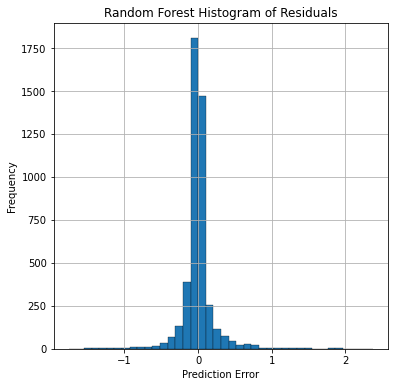

In [ ]:
plot_residuals_histogram(y_test, predicted_rf, 'Random Forest Histogram of Residuals', colour = 'tab:blue')

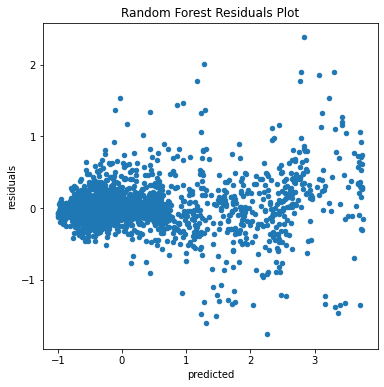

In [ ]:
plot_residuals_scatter(y_test, predicted_rf, 'Random Forest Residuals Plot', colour = 'tab:blue')

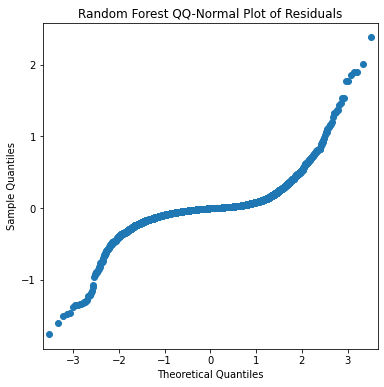

In [ ]:
plot_qq(y_test, predicted_rf, 'Random Forest QQ-Normal Plot of Residuals', colour = 'tab:blue')

## HDI prediction

Using the equation from http://hdr.undp.org/en/content/human-development-index-hdi.

In [ ]:
df = pd.read_csv('/content/gdrive/My Drive/AI Masters/Data Visualization/IndicatorsV2_Normalized.csv')

df['HDI'] = df['GNI (current US$)'] + \
            df['Life expectancy at birth, total (years)'] + \
            df['Expenditure on education as % of total government expenditure (%)']

train_data = df.drop(labels = ['Country', 'HDI', 'GNI (current US$)', 
                               'Life expectancy at birth, total (years)', 
                               'Expenditure on education as % of total government expenditure (%)'], axis = 1)
train_labels = df['HDI']

rfr_selector = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=490,
                                     max_features=75, max_leaf_nodes=None,
                                     min_impurity_decrease=0.0, min_impurity_split=None,
                                     min_samples_leaf=52, min_samples_split=251,
                                     min_weight_fraction_leaf=0.0, n_estimators=1300,
                                     n_jobs=None, oob_score=False, random_state=42, verbose=0,
                                     warm_start=False)

rfr_selector.fit(train_data, train_labels)

coefs = pd.Series(rfr_selector.feature_importances_, index = train_data.columns)

coefs.sort_values(ascending = False, inplace = True)

Text(0.5, 1.0, "Coefficients' importance as chosen by the random forest model.")

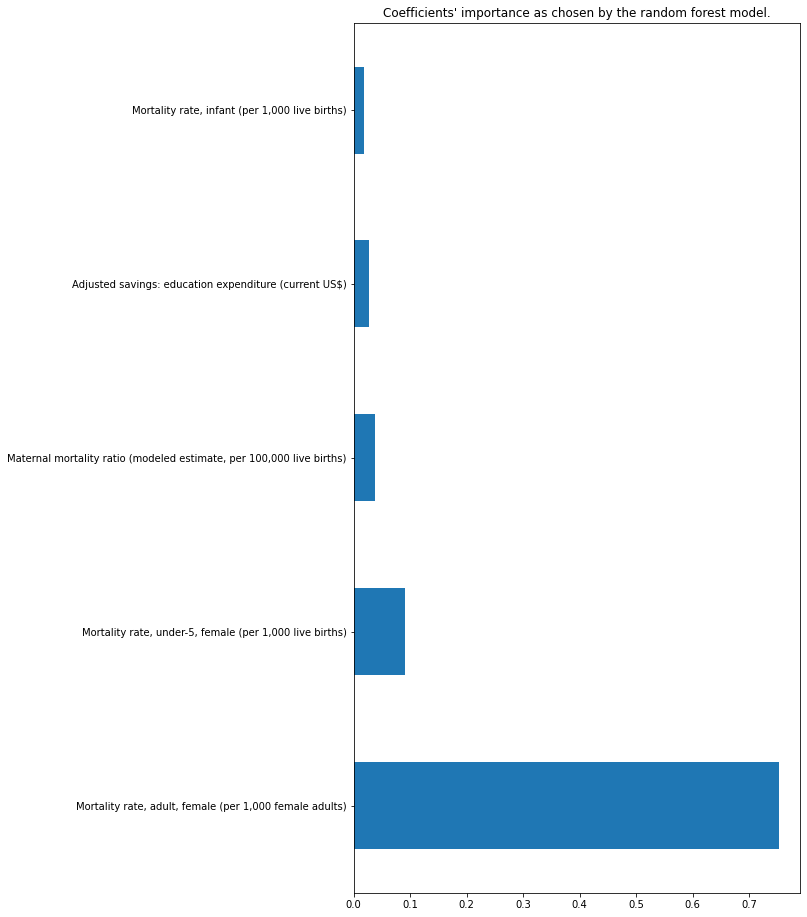

In [ ]:
coefs_for_plot = coefs[:5]
plt.rcParams['figure.figsize'] = (8.0, 16.0)
coefs_for_plot.plot(kind = "barh")
plt.title("Coefficients' importance as chosen by the random forest model.")

In [ ]:
cols = list(coefs.keys()[:30])
cols.append('Country')
cols.append('GDP per capita (current US$)')

df_select = df[cols]

parameters_cv_rf = {
  'bootstrap': [True],
  'n_estimators': [trees for trees in range(100, 2000, 50)],
  'max_depth': [depth for depth in range(10, 500, 10)],
  'min_samples_leaf': range(2, 100, 5),
  'min_samples_split': [sample for sample in range(2, 500, 50)],
  'max_features': [degree_freedom for degree_freedom in range(2, 37, 5)]
}

features = df_select.drop(['Country', 'GDP per capita (current US$)'], axis = 1)

labels = df_select['GDP per capita (current US$)'].values

rf_model = RandomForestRegressor(random_state = 42)

kf = KFold(n_splits = 10, shuffle = False, random_state = 1001)

random_search = RandomizedSearchCV(rf_model, 
                                   param_distributions = parameters_cv_rf, 
                                   n_iter = 10, 
                                   scoring = 'neg_mean_squared_error', 
                                   n_jobs = 100, 
                                   cv = kf.split(features, labels), 
                                   verbose = 10, 
                                   random_state = 1001)

random_search.fit(features, labels)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.
[Parallel(n_jobs=100)]: Done  11 out of 100 | elapsed:   58.2s remaining:  7.8min
[Parallel(n_jobs=100)]: Done  22 out of 100 | elapsed:  1.6min remaining:  5.6min
/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=100)]: Done  33 out of 100 | elapsed: 12.3min remaining: 25.0min
[Parallel(n_jobs=100)]: Done  44 out of 100 | elapsed: 40.4min remaining: 51.5min
[Parallel(n_jobs=100)]: Done  55 out of

RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x7f851d1708d0>,
                   error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf...
                              

In [ ]:
print('Best estimator:')
print(random_search.best_estimator_)
print('\n Best normalized gini score for %d-fold search with %d parameter combinations:' % (10, 10))
print(random_search.best_score_ * 2 - 1)
print('\n Best hyperparameters:')
print(random_search.best_params_)

Best estimator:
RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=220, max_features=17, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=47,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=1500, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

 Best normalized gini score for 10-fold search with 10 parameter combinations:
-1.4439977589784339

 Best hyperparameters:
{'n_estimators': 1500, 'min_samples_split': 2, 'min_samples_leaf': 47, 'max_features': 17, 'max_depth': 220, 'bootstrap': True}


In [ ]:
features = df.drop(['Country', 'HDI', 'GNI (current US$)', 
                            'Life expectancy at birth, total (years)', 
                            'Expenditure on education as % of total government expenditure (%)'], axis = 1)

labels = df['HDI'].values

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.33, random_state=42)

In [ ]:
rf_model = RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                                 max_depth=220, max_features=17, max_leaf_nodes=None,
                                 max_samples=None, min_impurity_decrease=0.0,
                                 min_impurity_split=None, min_samples_leaf=47,
                                 min_samples_split=2, min_weight_fraction_leaf=0.0,
                                 n_estimators=1500, n_jobs=None, oob_score=False,
                                 random_state=42, verbose=0, warm_start=False)

rf_model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=220, max_features=17, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=47,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=1500, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [ ]:
predicted_rf = rf_model.predict(X_test)

metrics_rf = compute_metrics(y_test, predicted_rf)

Maximum residuals error: 4.675461138412413
Mean squared error: 0.11570621120191203
Mean absolute error: 0.21431112820273238
R-squared score: 0.919967946536468
Explained variance: 0.9199794488989212


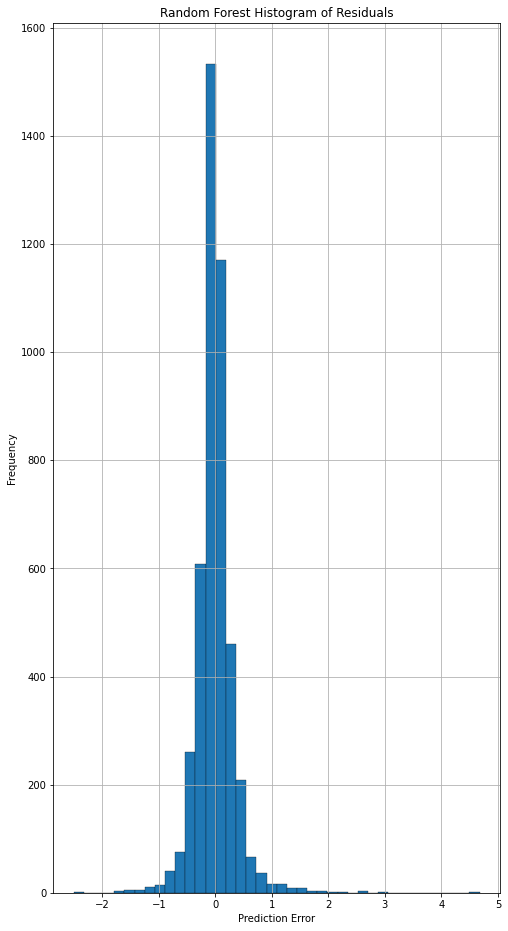

In [ ]:
plot_residuals_histogram(y_test, predicted_rf, 'Random Forest Histogram of Residuals', colour = 'tab:blue')

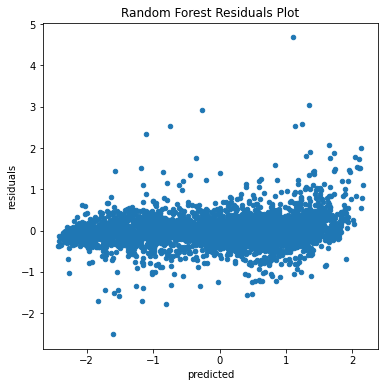

In [ ]:
plot_residuals_scatter(y_test, predicted_rf, 'Random Forest Residuals Plot', colour = 'tab:blue')

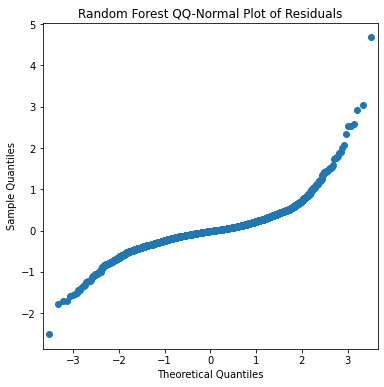

In [ ]:
plot_qq(y_test, predicted_rf, 'Random Forest QQ-Normal Plot of Residuals', colour = 'tab:blue')